# Análisis del dataset de entrenamiento


In [1]:
%pip install ipython==8.32.0 ipywidgets==8.1.5 nltk==3.9.1 ../humor-detection --q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from humor_detection.dataset import BaseTrain, Exclusive, LongLengths, Repetition, ShortLengths, Test, Train, TrainMultilingual, load_csv
from humor_detection.utils import set_random_seeds
from nltk import download
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer
from numpy import max
from pandas import DataFrame, Series
from wordcloud import WordCloud
import matplotlib.pyplot as plt

download('punkt')
download('stopwords')

set_random_seeds()

detection_classes = [0, 1]
spanish_stopwords = set(stopwords.words('spanish'))
tokenizer = TweetTokenizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ojcas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ojcas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Análisis de frecuencia de palabras


En textos de de humor es común que se sigan ciertos patrones o se utilicen ciertas palabras con sentido de humor como "JAJA" o "#humor" que los modelos pueden asociar erróneamente a niveles de humor durante el finetuning. También pueden haber palabras poco frecuentes entre la clases humor y no humor que el modelo pueden aprender a asociar a estas clases.

El objetivo de este análisis es extender el dataset de entrenamiento con instancias que incluyan estas palabras con sentido de humor para hacer más resistente el modelo a estos patrones y mejorar su rendimiento en las tareas de detección y clasificación. También se quiere evaluar el impacto de las palabras de humor del dataset de entrenamiento en el dataset de evaluación.

### 1.1. Dataset de entrenamiento

En esta sección se realiza un análisis de frecuencia de palabras por cada clase en el dataset de entrenamiento ubicado en la ruta `./data/processed/haha_train.csv` para identificar las palabras más frecuentes, poco frecuentes y con sentido de humor por clase.

Se define un conjunto de palabras o partes de palabras con significado relacionado a humor, como sinónimos o antónimos de humor, modos de humor, hashtags relacionados con humor, acrónimos de humor, algunas palabras comunes en inglés de humor y algunos emojis que expresa sentimiento de humor.


In [3]:
REPETITION_WORDS = ["jaja", "jajá", "haha", "xd", "lol"]


def contains_repetition(token: str):
    token = token.lower()
    for word in REPETITION_WORDS:
        if word in token:
            return True
    return False


def get_tokens_per_class(data: DataFrame):
    """
    Obtiene conjuntos de tokens completo y tokens de humor por clase.
    """
    result = {}
    for score in detection_classes:
        tokens = []
        for text in data[(data["score"] == 0) if score == 0 else (data["score"] > 0)][
            "text"
        ].to_list():
            for token in tokenizer.tokenize(text):
                if token.lower() not in spanish_stopwords:
                    tokens.append(token)
        freq_dist = FreqDist(tokens)
        most_common = freq_dist.most_common()
        quarter_point = len(most_common) // 5
        frequent = [token for token, _ in most_common[:quarter_point]]
        result[score] = {
            "frequent": frequent,
            "frequent_no_humor": [
                token for token in frequent if not contains_repetition(token)
            ],
            "repetition_tokens": [
                token for token in freq_dist.keys() if contains_repetition(token)
            ],
            "top_20": [
                token
                for token, _ in most_common[:quarter_point]
                if not contains_repetition(token)
            ],
            "top_80": [
                token
                for token, _ in most_common[: (quarter_point * 4)]
                if not contains_repetition(token)
            ],
        }
    return result


def plot_wordclouds(tokens_per_class: dict, tokens_set: str, max_words=200):
    """
    Muestra las nubes de tokens para cada clase.
    """
    set_random_seeds()
    _, axes = plt.subplots(1, 2, figsize=(6, 5))
    for i, score_class in enumerate(detection_classes):
        wordcloud = WordCloud(
            width=400,
            height=400,
            background_color="white",
            collocations=True,
            max_words=max_words,
        ).generate(" ".join(tokens_per_class[score_class][tokens_set]))
        y = i % 2
        axes[y].imshow(wordcloud, interpolation="bilinear")
        axes[y].axis("off")
        axes[y].set_title(f"Score {score_class}", fontsize=18)
    plt.tight_layout()
    plt.show()


def count_humor_tokens(text: str):
    count = 0
    for token in tokenizer.tokenize(text):
        if contains_repetition(token):
            count += 1
    return count


def plot_bars_humor_tokens(
    no_humor_counts: Series,
    humor_counts: Series,
    fix_y_pos=True,
):
    """
    Presenta un gráfico de barras apilado para conteos de textos con/sin tokens de humor en el dataset.
    """
    total_counts = humor_counts + no_humor_counts
    no_humor_percentages = no_humor_counts / total_counts * 100
    humor_percentages = humor_counts / total_counts * 100
    bottom = Series([0] * len(detection_classes))
    plt.figure(figsize=(5, 5))
    plt.bar(
        detection_classes,
        no_humor_counts,
        bottom=bottom,
        color="skyblue",
        label="Instancias sin tokens de humor",
    )
    for score_class in detection_classes:
        y = bottom[score_class] + no_humor_counts[score_class] / 2
        if fix_y_pos:
            y = 500 if y < 300 else y
        label = f"{no_humor_counts[score_class]:,} ({no_humor_percentages[score_class]:.1f}%)"
        plt.text(
            score_class, y, label, ha="center", va="center", fontsize=9, color="black"
        )
    bottom += no_humor_counts
    plt.bar(
        detection_classes,
        humor_counts,
        bottom=bottom,
        color="orange",
        label="Instancias con tokens de humor",
    )
    for score_class in detection_classes:
        y = bottom[score_class] + humor_counts[score_class] / 2
        if fix_y_pos:
            y = 1000 if y < 400 else y
        label = f"{humor_counts[score_class]:,} ({humor_percentages[score_class]:.1f}%)"
        plt.text(
            score_class, y, label, ha="center", va="center", fontsize=9, color="black"
        )
    bottom += humor_counts
    max_bottom = max([bottom[score_class] for score_class in detection_classes])
    for score_class in detection_classes:
        y = bottom[score_class] + max_bottom * 0.02
        if fix_y_pos:
            y = 1600 if y < 1500 else y
        label = f"{total_counts[score_class]:,}"
        plt.text(
            score_class,
            y,
            label,
            ha="center",
            va="center",
            fontsize=9,
            color="black",
            fontweight="bold",
        )
    plt.xticks(detection_classes)
    plt.xlabel("Clases")
    plt.ylabel("Instancias")
    plt.title("Detección - Instancias con/sin tokens de humor por clase")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
train_count_tokens = load_csv(BaseTrain)
train_count_tokens["repetition_tokens"] = train_count_tokens["text"].apply(
    count_humor_tokens
)
no_humor_counts_train = (
    train_count_tokens[train_count_tokens["repetition_tokens"] == 0]["score"]
    .value_counts()
    .sort_index()
)
humor_counts_train = (
    train_count_tokens[train_count_tokens["repetition_tokens"] > 0]["score"]
    .value_counts()
    .sort_index()
)

Para la tarea de clasificación, de las instancias etiquetadas con un nivel de humor (del 1 al 5), entre un 14% al 19% aproximadamente tienen tokens de humor.


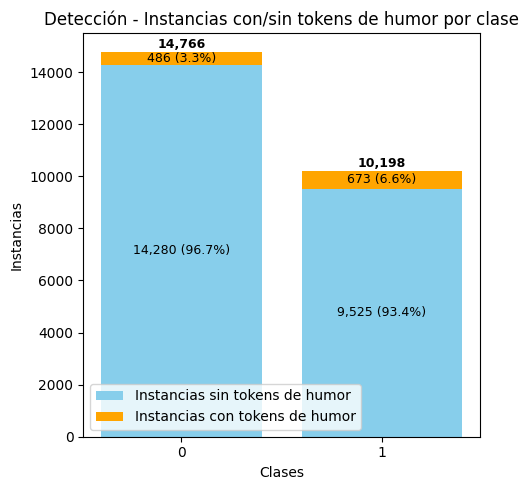

In [5]:
plot_bars_humor_tokens(
    Series(
        [no_humor_counts_train.iloc[0], no_humor_counts_train.iloc[1:].sum()], [0, 1]
    ),
    Series([humor_counts_train.iloc[0], humor_counts_train.iloc[1:].sum()], [0, 1]),
)

Para la tarea de detección, de las instancias etiquetadas como humor (clase 1), el 18% tienen tokens de humor.


In [6]:
class_tokens = get_tokens_per_class(train_count_tokens.copy())

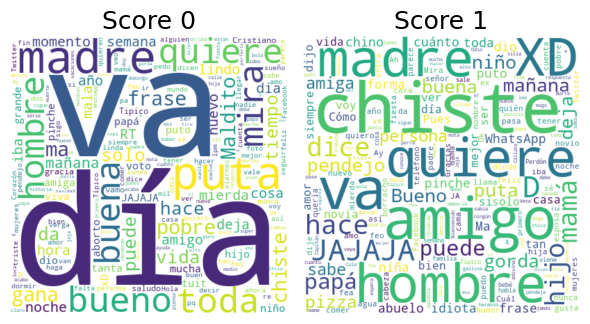

In [7]:
plot_wordclouds(class_tokens, "frequent")

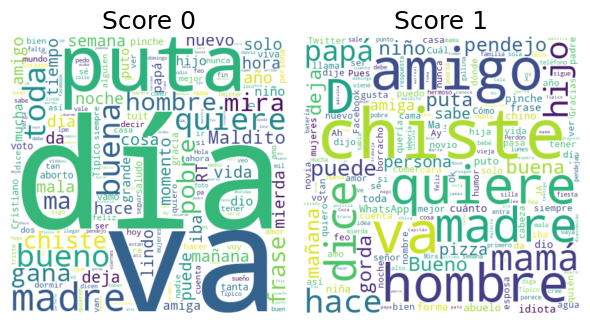

In [8]:
plot_wordclouds(class_tokens, "frequent_no_humor")

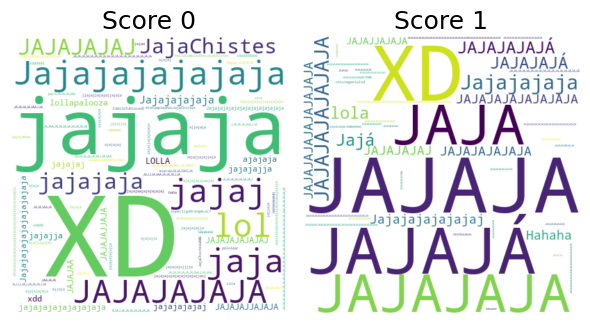

In [9]:
plot_wordclouds(class_tokens, "repetition_tokens")

Se encuentran un 357 tokens distintos en el dataset con significado de humor como 'chiste', 'jajajá' o 'humor'.

In [10]:
repetition_tokens = []
for score_class in detection_classes:
    repetition_tokens.extend(class_tokens[score_class]["repetition_tokens"])
repetition_tokens = sorted(set(repetition_tokens))
print(f"Tokens de humor encontrados: {len(repetition_tokens)}")

Tokens de humor encontrados: 229


### 1.2. Dataset de evaluación para detección

En esta sección se realiza un análisis de frecuencia de palabras por cada clase en el dataset de evaluación para la tarea de detección ubicado en la ruta `./data/detection/test.csv` para identificar las palabras más frecuentes, poco frecuentes y con sentido de humor por clase.

In [11]:
test_count_tokens = load_csv(Test.detection_path)
test_count_tokens["repetition_tokens"] = test_count_tokens["text"].apply(count_humor_tokens)
no_humor_counts_test = (
    test_count_tokens[test_count_tokens["repetition_tokens"] == 0]["score"]
    .value_counts()
    .sort_index()
)
humor_counts_test = (
    test_count_tokens[test_count_tokens["repetition_tokens"] > 0]["score"]
    .value_counts()
    .sort_index()
)

A continuación se calculará el porcentaje de instancias en el dataset con y sin estos tokens de humor para cada clase según la tarea detección.

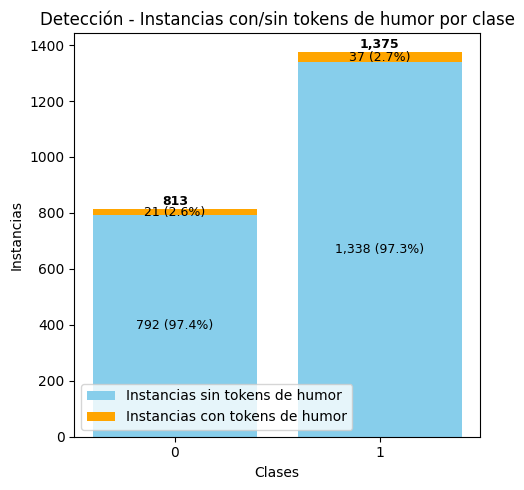

In [12]:
plot_bars_humor_tokens(no_humor_counts_test, humor_counts_test, False)

Para la tarea de detección, de las instancias etiquetadas como humor (clase 1), el 8.7% tienen tokens de humor.

## 2. Análisis de longitud de textos


En esta sección del notebook se hace un análisis de las longitudes de los textos en cada clase.

In [13]:
def get_stats_per_class(data_df: DataFrame, classes_list: list[int]) -> dict:
    """
    Calcula las estatísticas de las longitudes de los textos en el dataset.
    """
    stats_per_class = {}
    for score_class in classes_list:
        partition_df = data_df[data_df["score"] == score_class]
        stats_per_class[score_class] = {
            "mean": partition_df["length"].mean(),
            "std": partition_df["length"].std(),
            "min": partition_df["length"].min(),
            "max": partition_df["length"].max(),
        }
    return stats_per_class


def plot_histogram_text_lengths(data: DataFrame, bins: int, class_label: str):
    """
    Presenta un histograma de las longitudes de textos.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(data["length"], bins=bins, color="firebrick", edgecolor="firebrick")
    plt.title(f"Distribución de las longitudes de textos (Clase {class_label})")
    plt.xlabel("Longitud de textos (caracteres)")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

In [14]:
test_lengths = load_csv(Test.detection_path)
test_lengths["length"] = test_lengths["text"].str.len()

In [15]:
get_stats_per_class(test_lengths, detection_classes)

{0: {'mean': np.float64(125.75030750307504),
  'std': np.float64(184.41531996277936),
  'min': np.int64(6),
  'max': np.int64(2623)},
 1: {'mean': np.float64(218.66618181818183),
  'std': np.float64(242.5749179393568),
  'min': np.int64(28),
  'max': np.int64(2558)}}

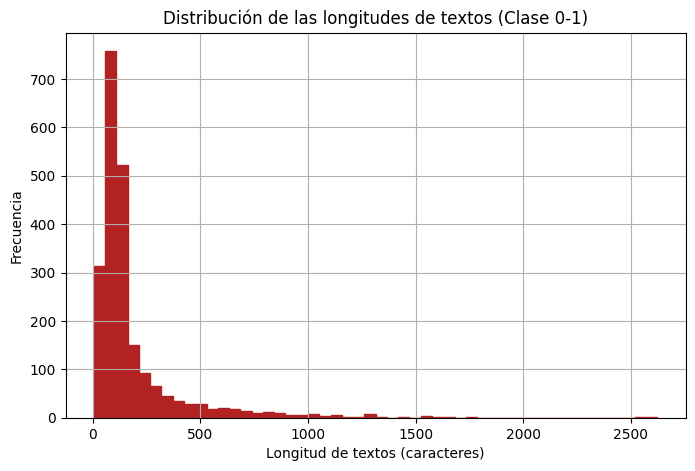

In [16]:
plot_histogram_text_lengths(test_lengths, 50, "0-1")

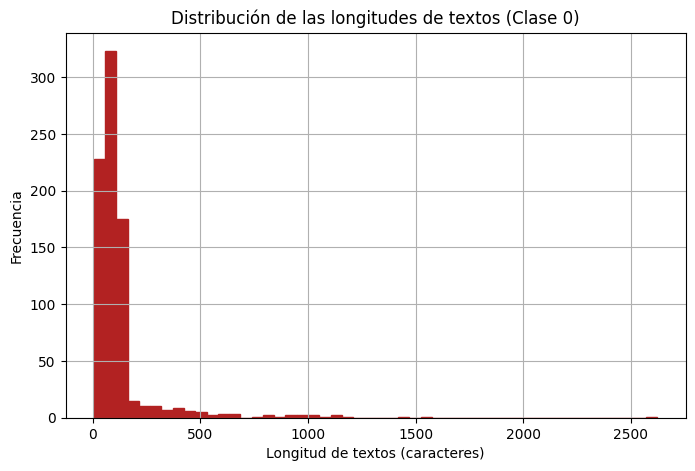

In [17]:
plot_histogram_text_lengths(
    test_lengths[test_lengths["score"] == 0], 50, "0"
)

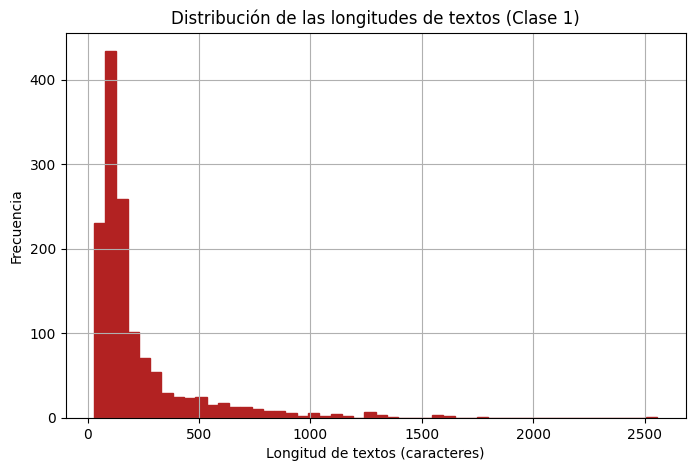

In [18]:
plot_histogram_text_lengths(
    test_lengths[test_lengths["score"] > 0], 50, "1"
)

De los histogramas se observa que ambas clases no humor 0 y humor 1 tienen una distribución similar donde la gran mayoría de textos se concentran en longitudes menores a 250 caracteres aproximadamente.

## 3. Generación de dataset sintético


### 3.1. Dataset sintético con tokens de humor


Se genera un dataset sintético de 2000 instancias de tamaño aleatorio, con tokens de humor junto con tokens seleccionados del vocabulario, clasificados como no humor (clase 0). Los pasos para cosntruir el dataset son:

- Se fija un tamaño de texto aleatorio entre los límites A y B.
- Seleccionar K tokens del conjunto total de tokens de humor y concatenarlo con los siguientes tokens.
- Seleccionar tokens del conjunto de tokens únicos de clase no humor 0 y concatenarlos hasta alcanzar el tamaño de texto fijado.
- Todos los textos se marcan como clase no humor 0.

El objetivo es generar un dataset que equilibre la proporción de instancias de textos con/sin tokens de humor.

### 3.2. Dataset sintético con tokens de humor y tokens menos/más frecuentes

Se genera un dataset sintético de 2000 ejemplos construido con textos originales del dataset de test concatenado con tokens de humor o de la intersección entre frecuentes y menos frecuentes del dataset de entrenamiento. Los pasos para construir el dataset son:

- Se toman textos aleatorios del dataset de test de las clases humor 0 y no humor 1.
- A los textos de clase no humor 0 se le agregan K tokens aleatorios de cualquiera de estos conjuntos:
    - Conjunto de tokens de humor encontrados en el dataset de entrenamiento.
    - Conjunto intersección entre tokens más frecuentes de la clase 1 y tokens menos frecuentes de la clase 0 en el dataset de entrenamiento.
- A los textos de clase humor 1 se le agregan K tokens aleatorios de cualquier de estos conjuntos:
    - Conjunto intersección entre tokens más frecuentes de la clase 0 y tokens menos frecuentes de la clase 1 en el dataset de entrenamiento.
- El score del texto resultante es el score del texto seleccionado en el dataset de test.

In [19]:
exclusive_tokens = get_tokens_per_class(load_csv(BaseTrain))

In [20]:
exclusive_humor = sorted(
    set(exclusive_tokens[1]["top_20"]) - set(exclusive_tokens[0]["top_80"])
)
exclusive_humor[:10]

['#Ane',
 '#Anecd',
 '#Anecdotas',
 '#CHISTE',
 '#Chis',
 '#Chist',
 '#Chiste',
 '#ChisteMachista',
 '#Cortitos',
 '#FrasesLocas']

In [21]:
exclusive_non_humor = sorted(
    set(exclusive_tokens[0]["top_20"]) - set(exclusive_tokens[1]["top_80"])
)
exclusive_non_humor[:10]

['#3PalabrasDolorosas',
 '#A2Beandas',
 '#AEROMEXICOTIENEPESIMOSERVICIO',
 '#AEROMÉXICOTIENEPÉSIMOSERVICIO',
 '#ATRenMTVHits',
 '#AbortoLegal',
 '#AbortoLegalYa',
 '#AlfredDirecto',
 '#ArtistaDelFestivalCNCO',
 '#ArtistaDelFestivalCNCO️']

In [22]:
Exclusive().process(exclusive_humor=exclusive_humor, exclusive_non_humor=exclusive_non_humor, rows=2000)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
Repetition().process(repetition_tokens=repetition_tokens, exclusive_humor=exclusive_humor, rows=2000)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 3.3. Dataset sintético de longitudes cortas y largas

Se genera un dataset sintético de 2000 ejemplos construido de longitudes cortas y largas con tokens del dataset de test. Los pasos para construir el dataset son:

- Se selecciona una clase aleatoria entre 0 y 1, y se obtienen las estadísticas de las longitudes (mean, std, max, min) de la clase seleccionada.
- Se fija un tamaño de más de 2 desviaciones estándar de la longitud media de los textos de la clase.
- Se construye el texto tomando tokens aleatorios del de conjunto tokens únicos de la clase hasta alcanzar el tamaño de texto fijado.
- El score del texto resultante es la clase seleccionada.

In [24]:
LongLengths().process()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
ShortLengths().process()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
base, classification, detection = Train().process()

base

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
classification

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
detection

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
base, classification, detection = TrainMultilingual().process()

base

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
classification

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
detection

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]